In [13]:
import re
import pandas as pd
from io import StringIO

FILENAME = 'data/train.csv'
with open(FILENAME) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

print(df)

         ImageID  Labels                                            Caption
0          0.jpg       1   Woman in swim suit holding parasol on sunny day.
1          1.jpg    1 19  A couple of men riding horses on top of a gree...
2          2.jpg       1  They are brave for riding in the jungle on tho...
3          3.jpg  8 3 13  a black and silver clock tower at an intersect...
4          4.jpg   8 3 7   A train coming to a stop on the tracks out side.
...          ...     ...                                                ...
29991  29995.jpg   8 1 2  A picture of a truck that is in the middle of ...
29992  29996.jpg       1  A plate topped with a pizza being cut with a s...
29993  29997.jpg       1          A man riding a snowboard on top of  snow.
29994  29998.jpg       1   This photo shows people skiing in the mountains.
29995  29999.jpg       1  Two young men playing soccer and fighting for ...

[29996 rows x 3 columns]


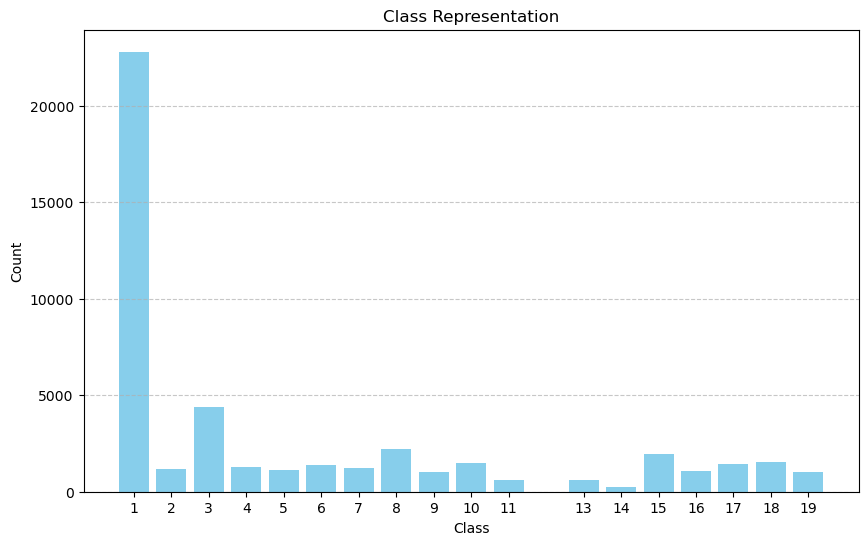

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_representation(dataframe):
    # Extract Labels column
    labels_column = dataframe['Labels']
    
    # Split the labels by space and convert them to integers
    labels_list = labels_column.str.split().explode().astype(int)
    
    # Count the occurrences of each label
    label_counts = labels_list.value_counts().sort_index()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.index, label_counts.values, color='skyblue')
    plt.title('Class Representation')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(label_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_representation(df)


## Manual Review of Data and Labelling

| Label | Guess                  |
|-------|------------------------|
| 1     | person??               |
| 2     | 2 wheel bike vehicle   |
| 3     | general vehicle? Car maybe |
| 4     | motorbike?             |
| 5     | plane                  |
| 6     | bus?                   |
| 7     | train                  |
| 8     | road??                 |
| 9     | boat / learned water?  |
| 10    | traffic lights? / signs|
| 11    | fire hydrant           |
| 13    | stop sign / sign       |
| 14    | parking meter          |
| 15    | bench                  |
| 16    | bird                   |
| 17    | cat                    |
| 18    | dog                    |
| 19    | horse                  |


In [15]:
def find_labels_containing_x(dataframe, class_find):
    """Helper method used to find rows with a certain class for visualisation"""
    rows_with_x = []
    
    # Loop over the DataFrame
    for index, row in dataframe.iterrows():
        labels = str(row['Labels']).split(" ")
        #print(labels)

        if class_find in labels:
            rows_with_x.append(row["ImageID"])
    
    return rows_with_x




In [16]:
from PIL import Image
import matplotlib.pyplot as plt

single_classed_labels = find_labels_containing_x(df, class_find="2")

def display_image(file_name):
    # Open the image file
    image = Image.open(file_name)
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

#Loop over the data to find 20 images with the specified class
k = 0
for i in single_classed_labels:
    file_name = "data/images/{}".format(i)
    #display_image(file_name)
    k += 1
    if k >= 20:
        break


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(image_path, width, height):
    """Preprocessing function used to do the following:
    1. Greyscale the images
    2. Resize the images by padding with white space
    3. Normalize images by division of 255"""
    # Display the original image
    
    image = cv2.imread(image_path)
    #display_image(image_path) #Used for visualising effect of preprocessing
    #print("Original image size: {}".format(image.shape))
    
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the dimensions of the grayscale image
    current_height, current_width = grayscale_image.shape[:2]
    # Calculate the amount of padding needed
    pad_width = max(width - current_width, 0)
    pad_height = max(height - current_height, 0)
    
    # Calculate the padding values
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left
    
    # Pad the grayscale image with white space
    padded_image = cv2.copyMakeBorder(grayscale_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255))
    
    # Resize the padded image to the specified width and height
    resized_image = cv2.resize(padded_image, (width, height))

    #normalize image by division of 255.0
    resized_image = resized_image / 255.0
    
    # Display the resized image
    # plt.imshow(resized_image, cmap='gray')
    # plt.axis('off')  # Turn off axis
    # plt.show()

    return resized_image

preprocessed_image = preprocess_image("./data/images/39988.jpg", 330, 330)

print("Processed image shape: {}".format(preprocessed_image.shape))


Processed image shape: (330, 330)


## Find max height and width of images

In [18]:
import os
import numpy as np
from PIL import Image

def find_image_sizes(directory):
    image_sizes = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            # Open the image file
            image_path = os.path.join(directory, filename)
            with Image.open(image_path) as img:
                # Get the dimensions of the image
                width, height = img.size
                # Append size to the list
                image_sizes.append((width, height))
    
    return image_sizes

def calculate_stats(image_sizes):
    # Convert list of tuples to numpy array for easier calculations
    image_sizes_array = np.array(image_sizes)
    
    # Calculate max, min, and standard deviation
    max_size = np.max(image_sizes_array, axis=0)
    min_size = np.min(image_sizes_array, axis=0)
    std_dev = np.std(image_sizes_array, axis=0)
    
    return max_size, min_size, std_dev

# Example usage:
directory = "./data/images/"  # Replace "images" with the directory containing your images
image_sizes = find_image_sizes(directory)
max_size, min_size, std_dev = calculate_stats(image_sizes)

print("Max Size:", max_size)
print("Min Size:", min_size)
print("Standard Deviation of Size:", std_dev)


Max Size: [320 320]
Min Size: [29 25]
Standard Deviation of Size: [45.84001473 48.45425533]


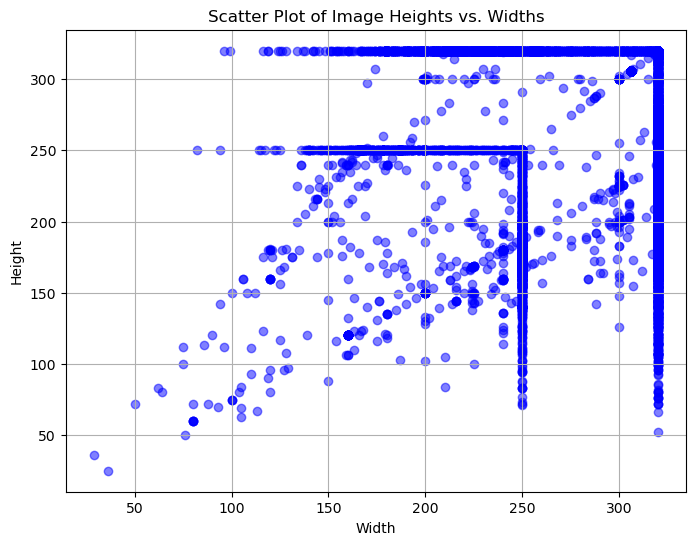

In [19]:

widths, heights = zip(*image_sizes)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, color='blue', alpha=0.5)
plt.title('Scatter Plot of Image Heights vs. Widths')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()

### Pre-Process all Data

In [4]:
import os
import cv2

def process_directory(input_directory, output_directory, width, height):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        if filename.lower().endswith((".jpeg", ".jpg")):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)

            # Process the image
            preprocessed_image = preprocess_image(input_path, width, height)

            preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
            cv2.imwrite(output_path, preprocessed_image)

input_directory = './data/images'
output_directory = './processeddata/processed_images'
process_directory(input_directory, output_directory, 330, 330)
